## Introduction
This notebook deals with unsupervised clustering of customers data from a groceries firm's database. Customer segmentation separates customers into groups that reflect similarities among customers. Customers are divided into segments to optimize the significance of each customer to a business, in order to modify products according to distinct needs and behaviors of customers. Helps the business to cater to the concerns of different types of customers.  

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA 
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')
np.random.seed(42)



## Loading Data


In [4]:
#loading the data
data = pd.read_csv('marketing_campaign.csv', sep='\t')
print("Shape of the data is", data.shape)
data.head()

Shape of the data is (2240, 29)


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## Data Cleaning 

In [5]:
#get the information on the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
#we can see that there are missing values but lets get a better idea
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [7]:
#there are missing values in income will just drop as it is not a lot
data = data.dropna()
data.shape

(2216, 29)

In [8]:
#Now need a proper dt_customer column as datetime and not an object
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-nul

In [10]:
#now that the data is in the proper format going to make a feature that shows how long a customer has been with the grocer.
dates = []
for i in data['Dt_Customer']:
    i = i.date()
    dates.append(i)

print(min(dates))
print(max(dates))

2012-01-08
2014-12-06


In [11]:
days = []
d1 = max(dates)
for i in dates:
    delta = d1-i
    days.append(delta)

data['Customer_For'] = days
data['Customer_For'] = pd.to_numeric(data['Customer_For'], errors='coerce')


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-nul

In [13]:
#now will be looking at categorical features to see there value counts
print(data['Marital_Status'].value_counts())
print(data['Education'].value_counts())

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [14]:
#now will be doing some feature engineering 

#want to get the age of every customer
data['Age'] = 2021-data['Year_Birth']

#total spending on various items
data['Spent'] = data['MntFishProducts'] + data['MntFruits'] + data['MntGoldProds'] + data['MntMeatProducts'] + data['MntSweetProducts'] + data['MntWines']

#replace living situation with marital status
data['Living_With'] = data['Marital_Status'].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone",
                                                      "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone","Single":"Alone"})

#now want how many children
data['Children'] = data['Kidhome'] + data['Teenhome']

#now total number in the house hold
data['Family_Size'] = data['Living_With'].replace({"Alone":0, "Partner":1}) + data['Children']

#is parent
data['Is_Parent'] = np.where(data.Children > 0,1,0)

#segmenting education level in three groups
data['Education'] = data['Education'].replace({"Basic":"Undergraduate", "2n Cycle":"Undergraduate", "Graduate":"Graduate",
                                               "Master":"Postgraduate", "PhD":"Postgraduate"})
#for clarity
data = data.rename(columns={"MntWines":"Wines", "MntFruits":"Fruits", "MntMeatProducts":"Meat", 
                            "MntFishProducts":"Fish", "MntSweetsProducts":"Sweets", "MntGoldProducts":"Gold"})

#Dropping some of the redundant features
to_drop = ['Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
data = data.drop(to_drop, axis=1)

In [15]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish  MntSweetProducts  MntGoldProds  \
count  2216.000000  2216.000000  2216.000000       2216.000000   2216.000000   
mean     26.356047   166.995939    37.637635         27.028881     43.965253   
std      39.793917   224.283273    54.752082         41.072046     51.815414   
min       0.000000     0.000000     0.000000          0.000000      0.000000   
25%       2.000000    16.000000     3.000000          1.000000      9.000000   
50%       8.000000    68.000000    12.000000          8.000000     24.500000   
75%      33.000000   232.250000    50.000000         33.000000     56.000000   
max     199.000000  1725.000000   259.000000        262.000000    321.000000   

       ...  AcceptedCmp1  AcceptedCmp2     Complain     Response  \
count  ...   2216.000000   2216.000000  2216.000000  2216.000000   
mean   ...      0.064079      0.013538     0.009477     0.150271   
std    ...      0.244950      0.115588     0.096907     0.357417   
min    ...      0.000000      0.000000     0.000000     0.000000   
25%    ...      0.000000      0.000000     0.000000     0.000000   
50%    ...      0.000000      0.000000     0.000000     0.000000   
75%    ...      0.000000      0.000000     0.000000     0.000000   
max    ...      1.000000      1.000000     1.000000     1.000000   

       Customer_For          Age        Spent     Children  Family_Size  \
count  2.216000e+03  2216.000000  2216.000000  2216.000000  2216.000000   
mean   4.423735e+16    52.179603   607.075361     0.947202     1.592509   
std    2.008532e+16    11.985554   602.900476     0.749062     0.905722   
min    0.000000e+00    25.000000     5.000000     0.000000     0.000000   
25%    2.937600e+16    44.000000    69.000000     0.000000     1.000000   
50%    4.432320e+16    51.000000   396.500000     1.000000     2.000000   
75%    5.927040e+16    62.000000  1048.000000     1.000000     2.000000   
max    9.184320e+16   128.000000  2525.000000     3.000000     4.000000   

         Is_Parent  
count  2216.000000  
mean      0.714350  
std       0.451825  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  

[8 rows x 28 columns]

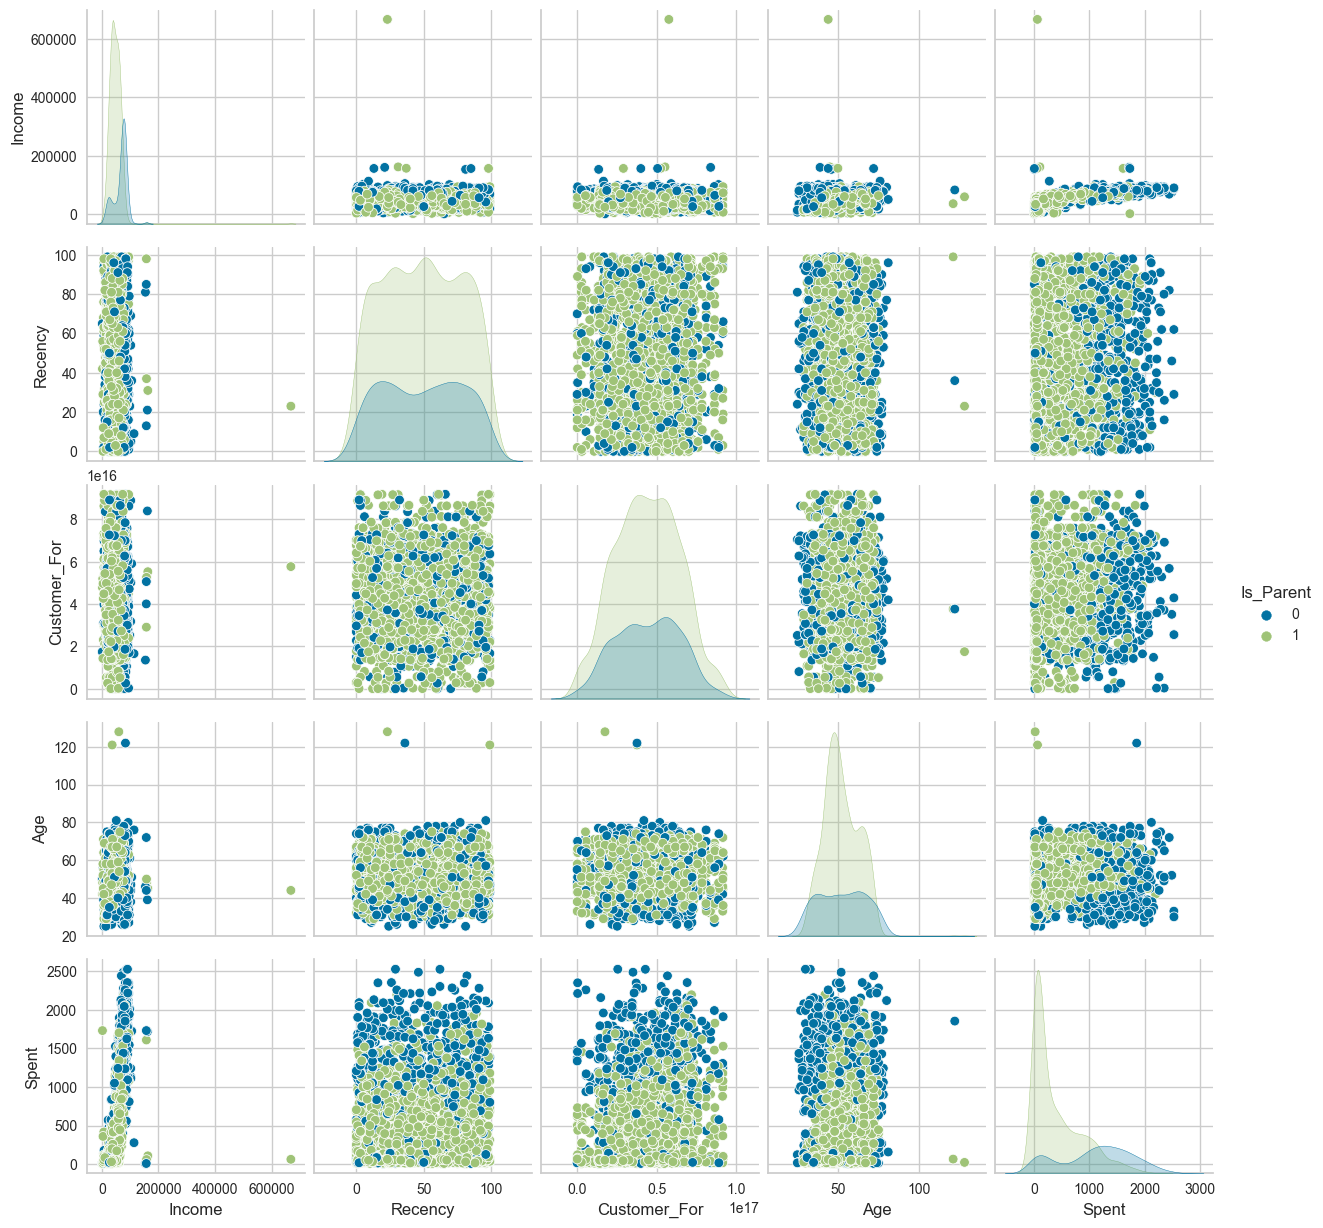

In [16]:
#plot some of the data
to_plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
sns.pairplot(data[to_plot], hue="Is_Parent")
plt.show()

In [17]:
#getting the outliers out
data = data[(data['Age']<90)]
data = data[(data['Income']<600000)]
data.shape

(2212, 30)

<Figure size 2000x2000 with 0 Axes>

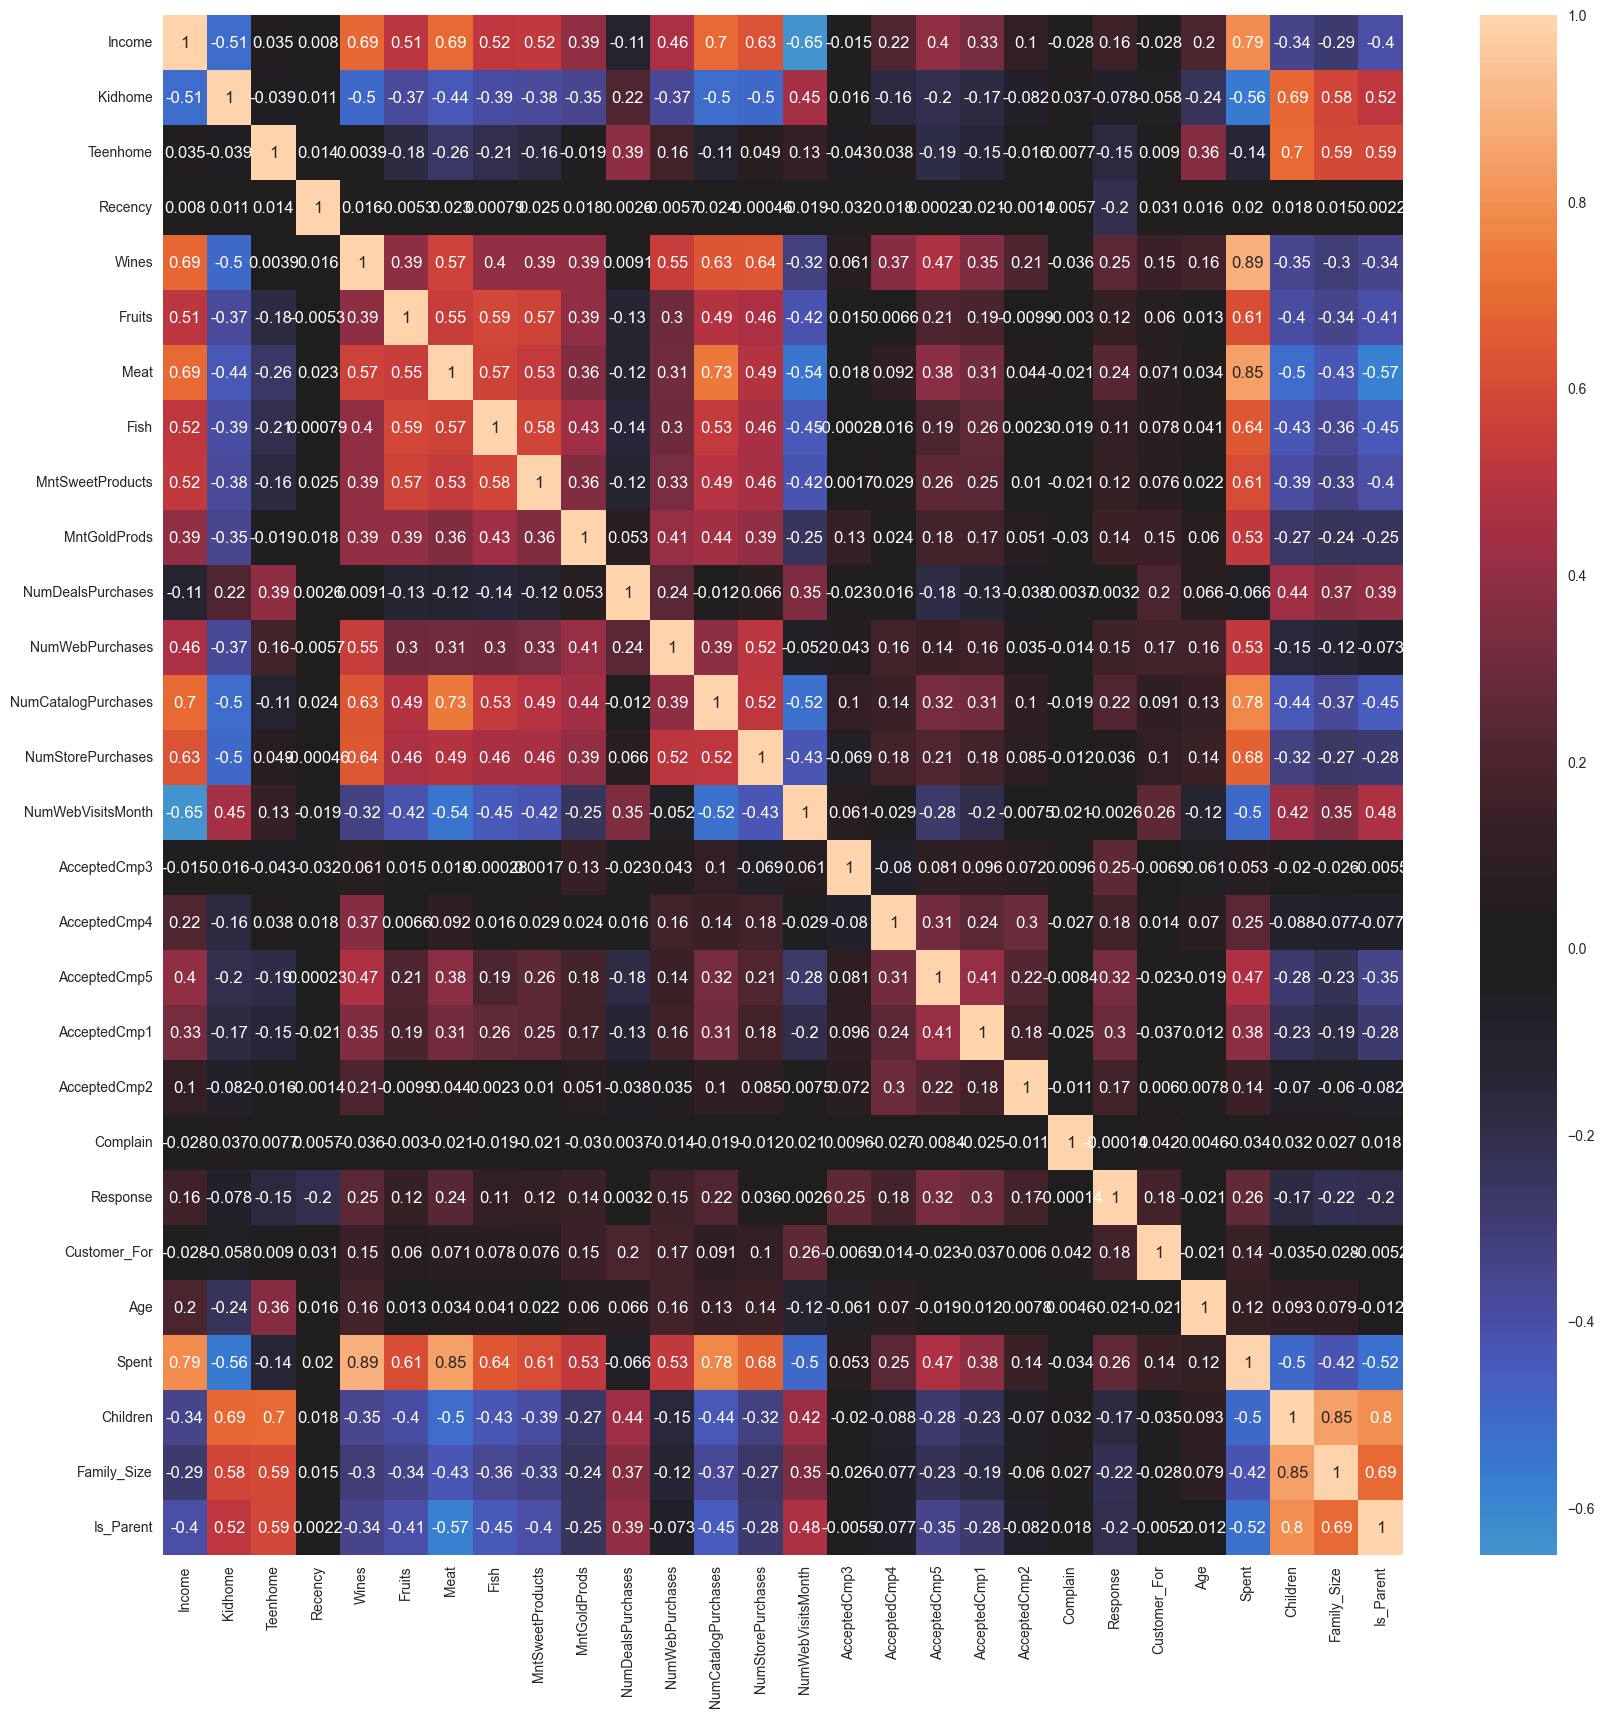

In [20]:
#looking at a correlation matrix
corrmat = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, center=0)
plt.show()

## Data Preprocessing
Preprocessing Data to preform clustering 

In [21]:
#get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical features are {}".format(object_cols))

Categorical features are ['Education', 'Living_With']


In [22]:
#Label Encoding the object dtypes
LE = LabelEncoder()
for i in object_cols:
    data[i] = data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [23]:
#creating a copy of the data
ds = data.copy()
#creating a subset of the data frame by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)


In [24]:
#Scaling the data
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns=ds.columns)
print('All features are now scaled')

All features are now scaled


In [25]:
#scaled data to be used for reducing dimensionality
print('Dataframe to be used for further modeling:')
scaled_ds.head()

Dataframe to be used for further modeling:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish  MntSweetProducts  ...  NumCatalogPurchases  \
0  1.690293  2.453472          1.483713  ...             2.503607   
1 -0.718230 -0.651004         -0.634019  ...            -0.571340   
2 -0.178542  1.339513         -0.147184  ...            -0.229679   
3 -0.655787 -0.504911         -0.585335  ...            -0.913000   
4 -0.218684  0.152508         -0.001133  ...             0.111982   

   NumStorePurchases  NumWebVisitsMonth  Customer_For       Age     Spent  \
0          -0.555814           0.692181      1.973583  1.018352  1.676245   
1          -1.171160          -0.132545     -1.665144  1.274785 -0.963297   
2           1.290224          -0.544908     -0.172664  0.334530  0.280110   
3          -0.555814           0.279818     -1.923210 -1.289547 -0.920135   
4           0.059532          -0.132545     -0.822130 -1.033114 -0.307562   

   Living_With  Children  Family_Size  Is_Parent  
0    -1.349603 -1.264598    -1.758359  -1.581139  
1    -1.349603  1.404572     0.449070   0.632456  
2     0.740959 -1.264598    -0.654644  -1.581139  
3     0.740959  0.069987     0.449070   0.632456  
4     0.740959  0.069987     0.449070   0.632456  

[5 rows x 23 columns]

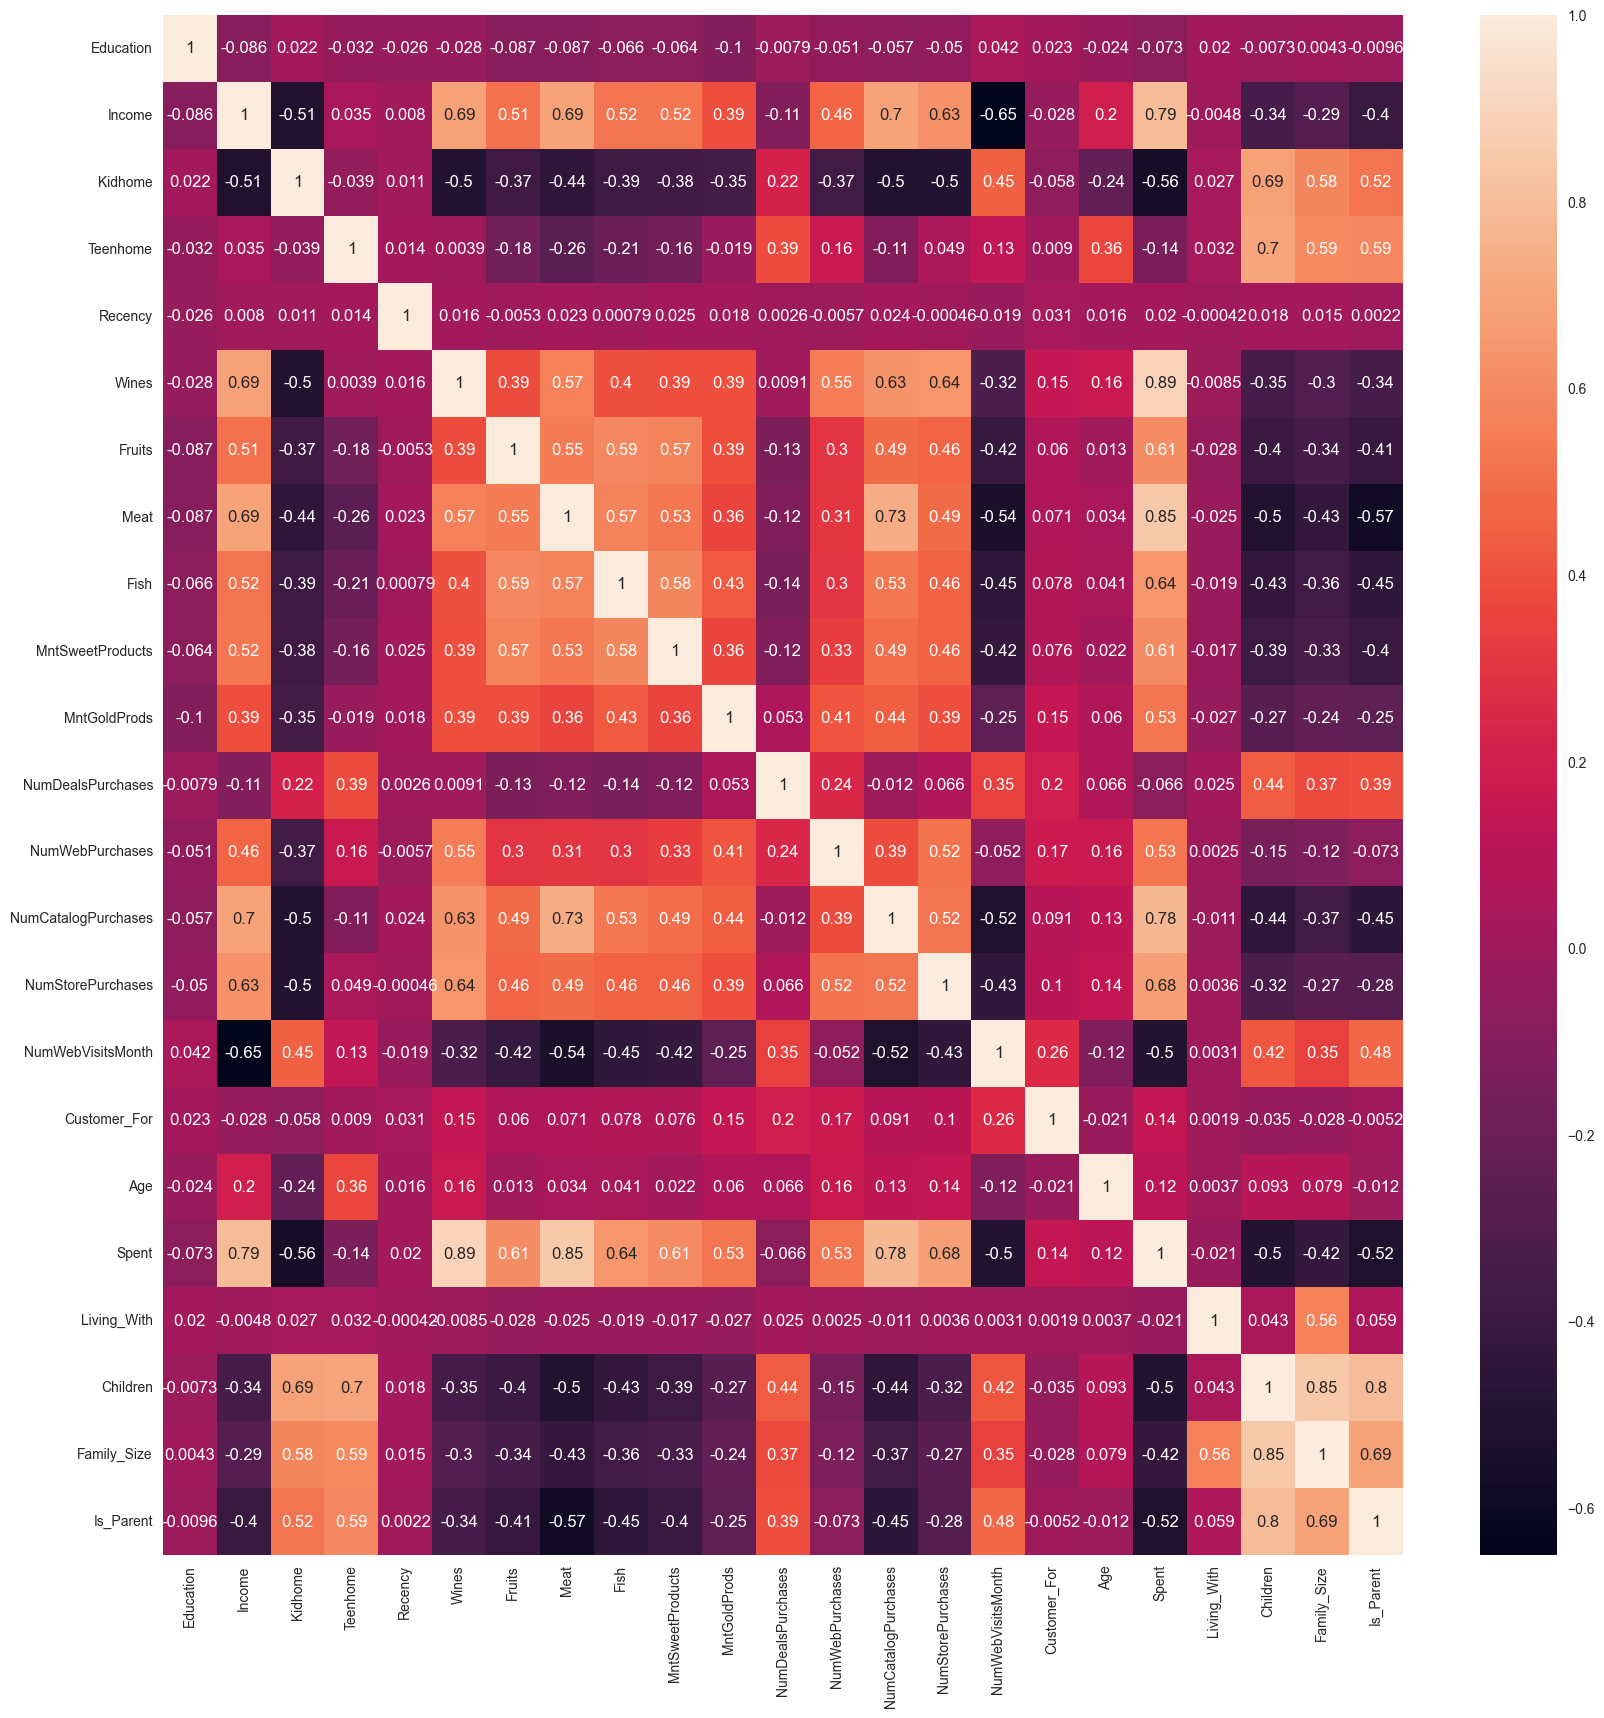

In [27]:
#looking at a correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(scaled_ds.corr(), annot=True)
plt.show()

## Dimensionality Reduction
Many of the features are correlated and hence redundant. Will use dimensionality reduction before putting through a classifier. Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principle variables. 

In [28]:
#initializing PCA to reduce features to three. 
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(['col1', 'col2', 'col3']))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0 -3.854662e-17  2.878377 -5.969394 -2.538494 -0.780421  2.383290   
col2  2212.0 -2.569775e-17  1.706839 -4.312196 -1.328316 -0.158123  1.242289   
col3  2212.0  5.701688e-17  1.221956 -3.530416 -0.829067 -0.022692  0.799895   

           max  
col1  7.444305  
col2  6.142721  
col3  6.611222

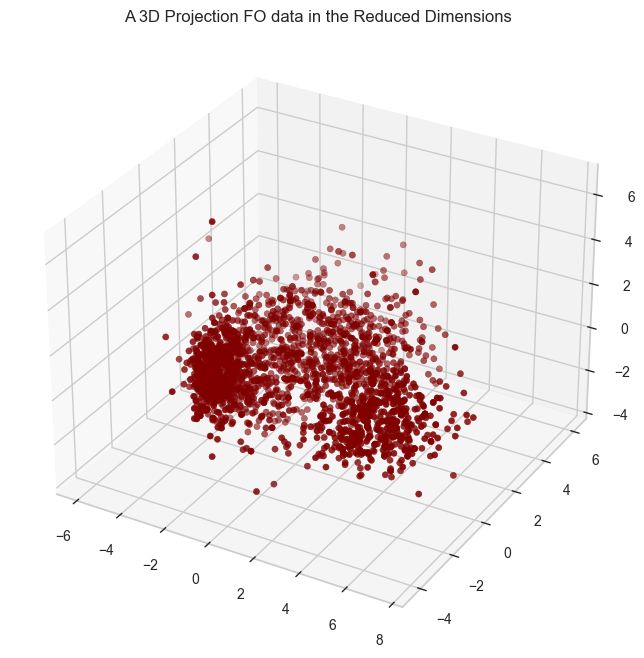

In [29]:
#A 3d Projection of Data in the Reduced Dimension
x = PCA_ds['col1']
y = PCA_ds['col2']
z = PCA_ds['col3']

#to plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c="maroon",  marker='o')
ax.set_title("A 3D Projection FO data in the Reduced Dimensions")
plt.show()

### Clustering 


Elbow method to determine the number of clusters to be formed


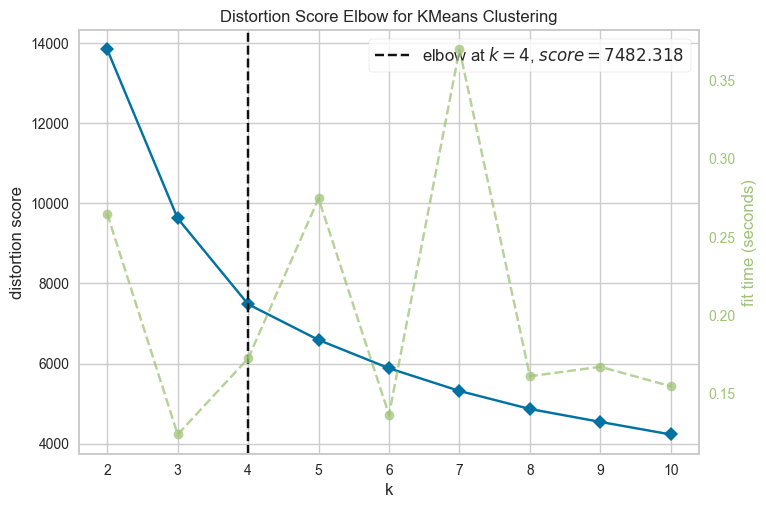

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
#quick examination of the elbow method to find the number of clusters
print('Elbow method to determine the number of clusters to be formed')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Here we see that 4 is the optimal number of clusters for this data. 


In [32]:
#initiating Agglomerative Clustering 
AC = AgglomerativeClustering(n_clusters=4)
#fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds['Clusters'] = yhat_AC
#adding clusters feature to the original dataframe
data['Clusters'] = yhat_AC

In [33]:
data

Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  \
0             0  58138.0        0         0       58    635      88   546   
1             0  46344.0        1         1       38     11       1     6   
2             0  71613.0        0         0       26    426      49   127   
3             0  26646.0        1         0       26     11       4    20   
4             1  58293.0        1         0       94    173      43   118   
...         ...      ...      ...       ...      ...    ...     ...   ...   
2235          0  61223.0        0         1       46    709      43   182   
2236          1  64014.0        2         1       56    406       0    30   
2237          0  56981.0        0         0       91    908      48   217   
2238          1  69245.0        0         1        8    428      30   214   
2239          1  52869.0        1         1       40     84       3    61   

      Fish  MntSweetProducts  ...  Complain  Response       Customer_For  Age  \
0      172                88  ...         0         1  83894400000000000   64   
1        2                 1  ...         0         0  10800000000000000   67   
2      111                21  ...         0         0  40780800000000000   56   
3       10                 3  ...         0         0   5616000000000000   37   
4       46                27  ...         0         0  27734400000000000   40   
...    ...               ...  ...       ...       ...                ...  ...   
2235    42               118  ...         0         0  46742400000000000   54   
2236     0                 0  ...         0         0   5270400000000000   75   
2237    32                12  ...         0         0  27216000000000000   40   
2238    80                30  ...         0         0  27302400000000000   65   
2239     2                 1  ...         0         1  67564800000000000   67   

      Spent  Living_With  Children  Family_Size  Is_Parent  Clusters  
0      1617            0         0            0          0         2  
1        27            0         2            2          1         3  
2       776            1         0            1          0         2  
3        53            1         1            2          1         1  
4       422            1         1            2          1         0  
...     ...          ...       ...          ...        ...       ...  
2235   1341            1         1            2          1         0  
2236    444            1         3            4          1         0  
2237   1241            0         0            0          0         2  
2238    843            1         1            2          1         0  
2239    172            1         2            3          1         0  

[2212 rows x 31 columns]

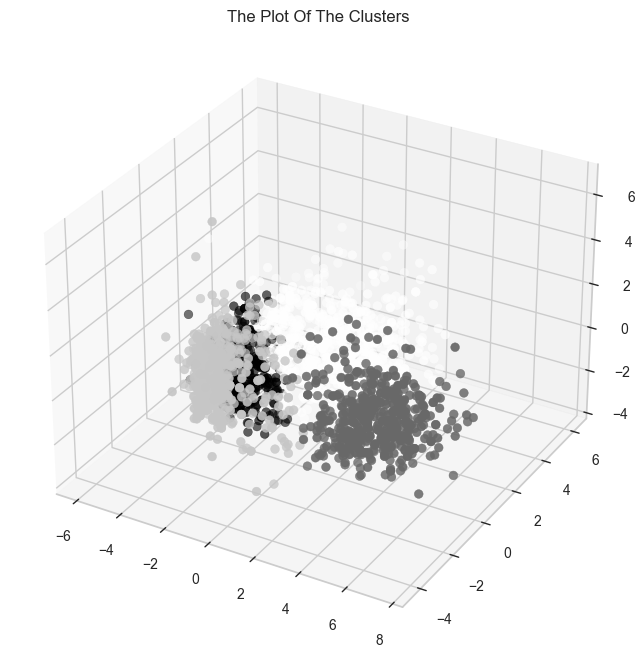

In [34]:
#plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection = '3d', label="bla")
ax.scatter(x,y,z, s=40, c=PCA_ds['Clusters'], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

### Evaluating Models


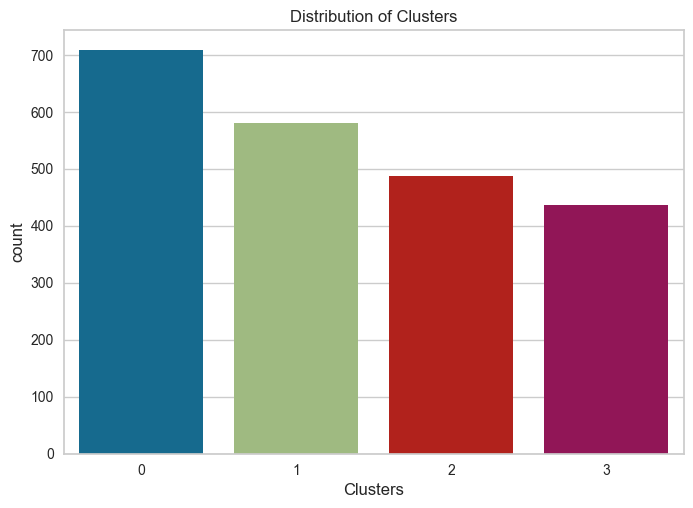

In [37]:
pl = sns.countplot(x=data['Clusters'])
pl.set_title("Distribution of Clusters")
plt.show()

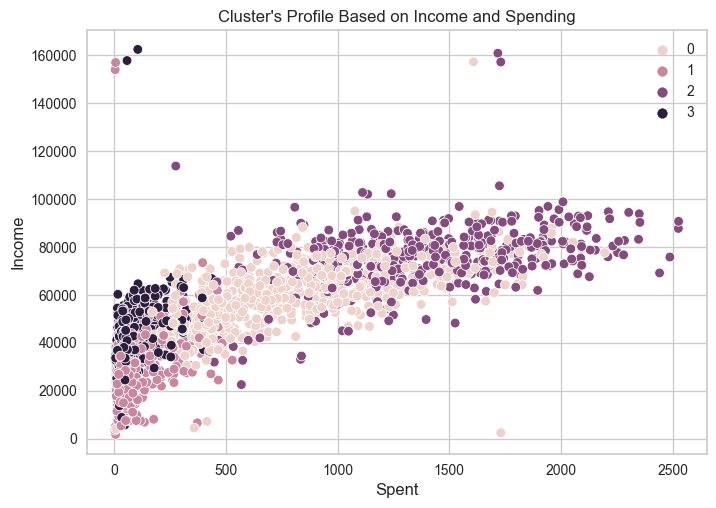

In [39]:
pl = sns.scatterplot(data=data, x=data['Spent'], y=data['Income'], hue=data['Clusters'])
pl.set_title("Cluster's Profile Based on Income and Spending")
plt.legend()
plt.show()

Here we see the four groups from the spending and income levels
1. group 0 = medium spending, average income
2. group 1 = low spending, low income
3. group 2 = high spending, high income
4. group 3 = low spending, average income

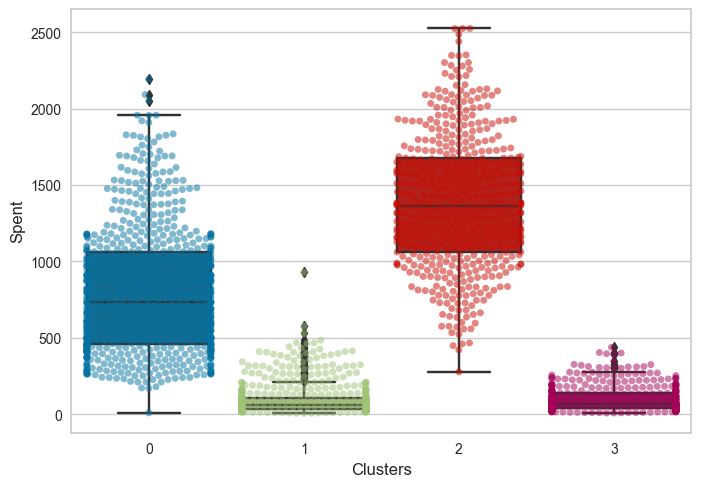

In [40]:
#now we will look at the detailed distribution of clusters as per the various products in the data. Namely wines, Fruits, Meat, Fish, Sweets, and Gold
plt.figure()
pl = sns.swarmplot(x=data['Clusters'], y=data['Spent'], alpha=0.5)
pl = sns.boxplot(x=data['Clusters'], y=data['Spent'])
plt.show() 

We see that our biggest set of customers is in clusters 0 and 2. We can explore what each cluster is spending on for the targeted marketing strategies.

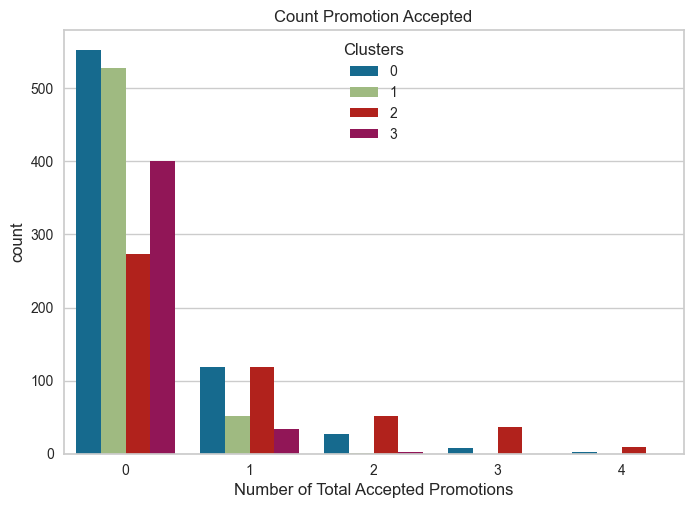

In [41]:
#let's see how the campaigns did in the past. 
#creating a feature plot fo get a sum of accepted promotions
data['Total_Promos'] = data["AcceptedCmp1"] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']
plt.figure()
pl = sns.countplot(x=data['Total_Promos'], hue=data['Clusters'])
pl.set_title("Count Promotion Accepted")
pl.set_xlabel('Number of Total Accepted Promotions')
plt.show()

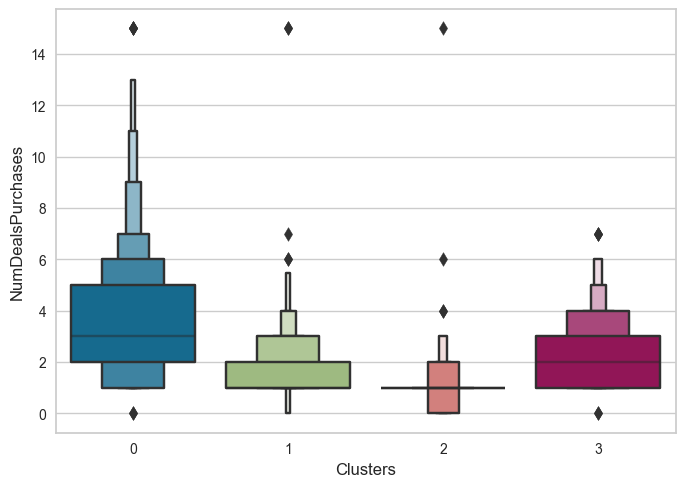

In [42]:
#plotting the number of deals purchased
plt.figure()
p1 = sns.boxenplot(y=data['NumDealsPurchases'], x=data['Clusters'])
pl.set_title("Number of Deals Purchased")
plt.show()

#unlike campaigns deals offered did well. Most deals where had in clusters 1 and 3. Cluster 2 high spending high income did not take advantage of deals. 

### Profiling
Let's look at the purchasing habits. See who is in the three clusters. 

In [43]:
data.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Customer_For', 'Age', 'Spent', 'Living_With',
       'Children', 'Family_Size', 'Is_Parent', 'Clusters', 'Total_Promos'],
      dtype='object')

In [49]:
Personal = ["Kidhome", "Teenhome", "Customer_For", "Age", "Family_Size", "Is_Parent", "Education", "Living_With"]

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

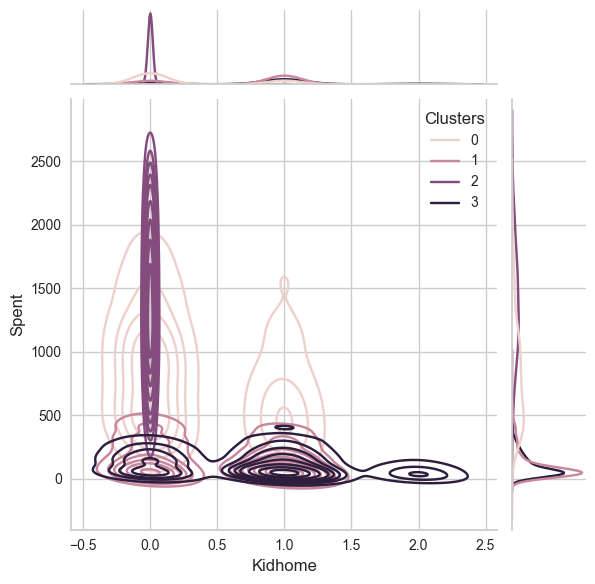

<Figure size 800x550 with 0 Axes>

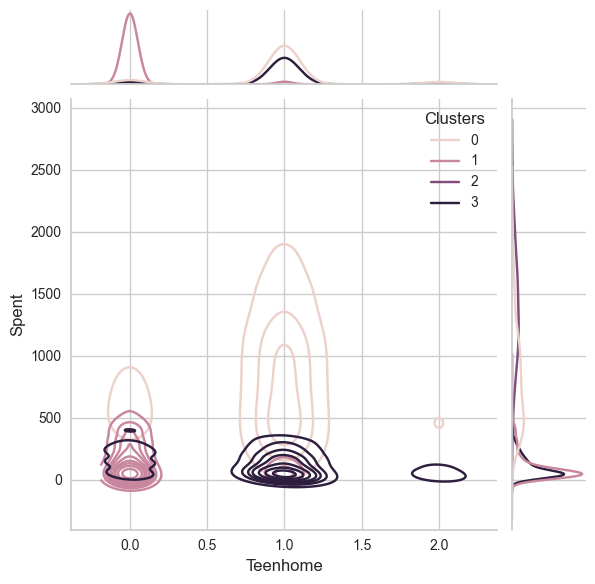

<Figure size 800x550 with 0 Axes>

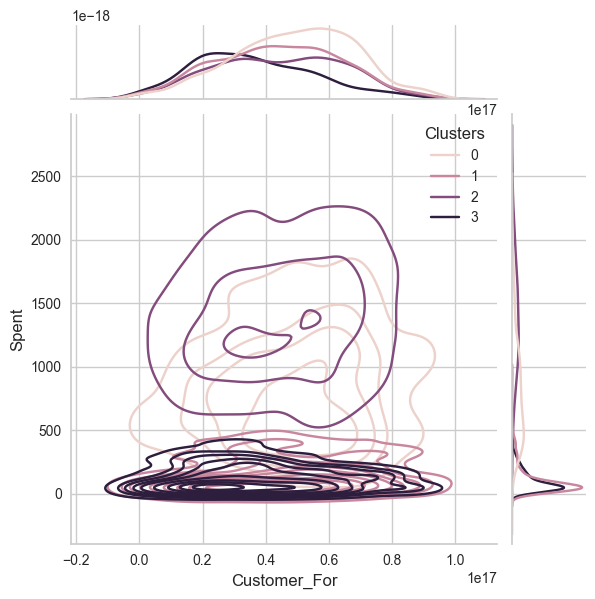

<Figure size 800x550 with 0 Axes>

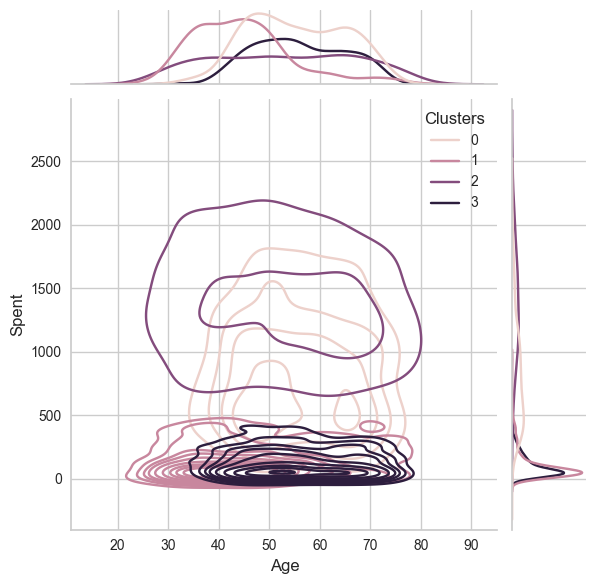

<Figure size 800x550 with 0 Axes>

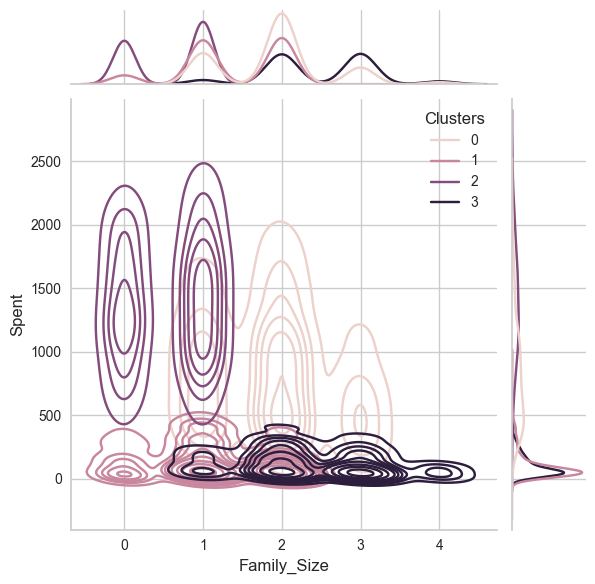

<Figure size 800x550 with 0 Axes>

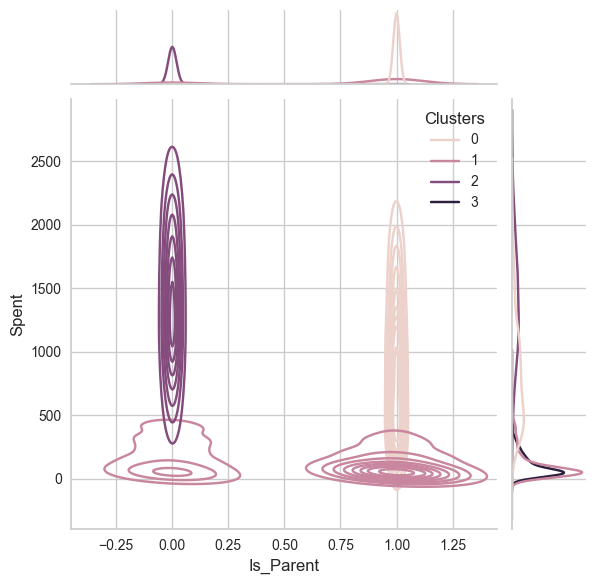

<Figure size 800x550 with 0 Axes>

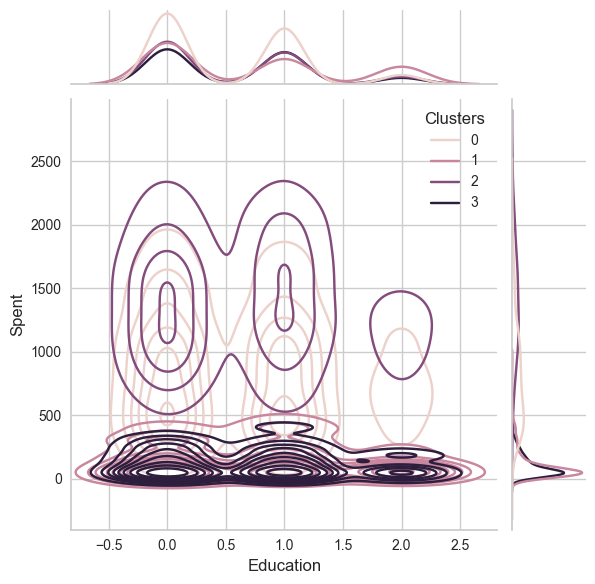

<Figure size 800x550 with 0 Axes>

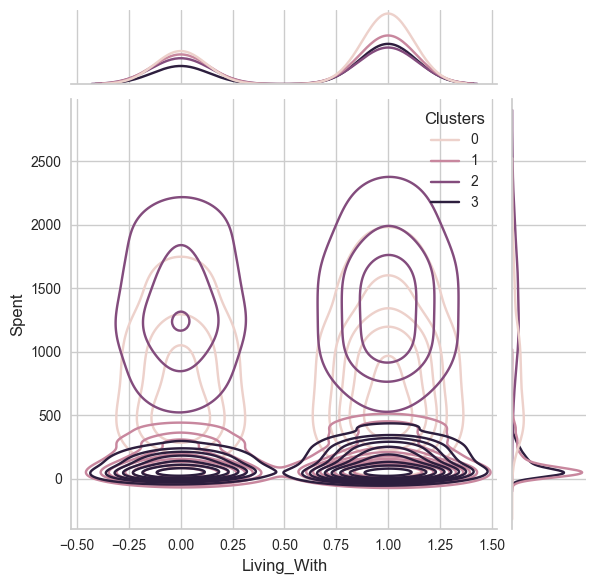

In [50]:
for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data['Spent'], hue=data['Clusters'], kind="kde")
    plt.show()

In [51]:
data['Kidhome'].value_counts()

0    1281
1     885
2      46
Name: Kidhome, dtype: int64

<Figure size 800x550 with 0 Axes>

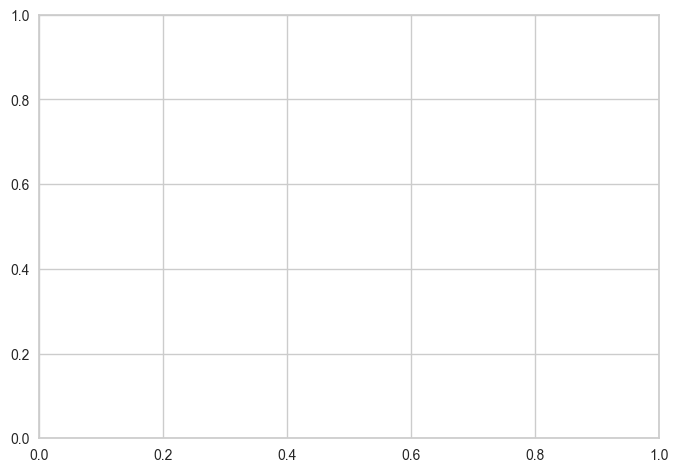

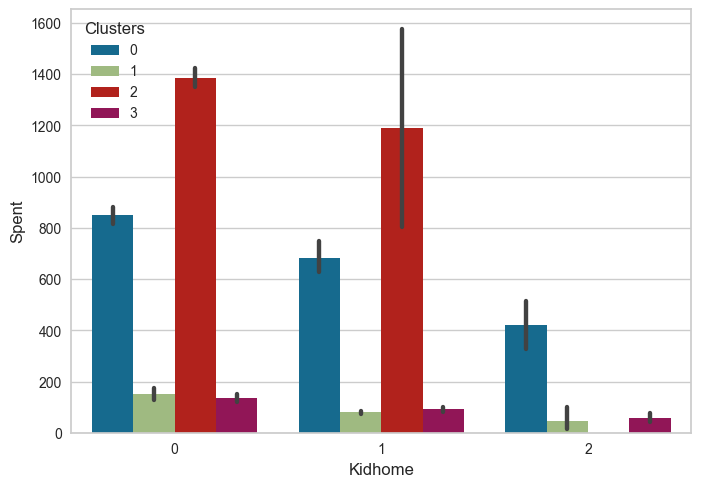

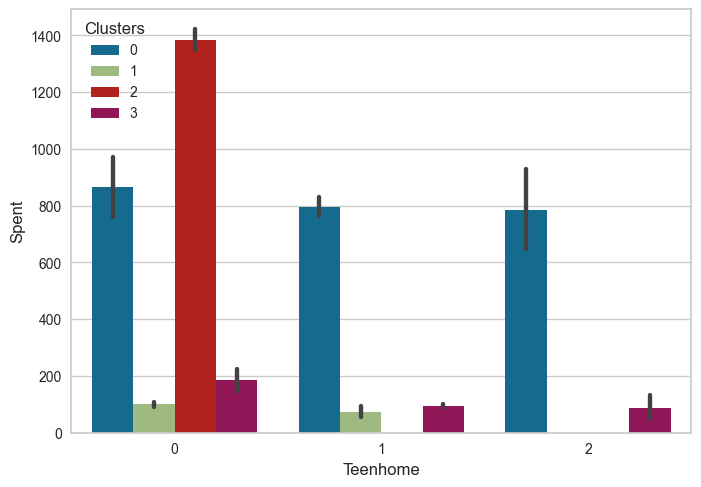

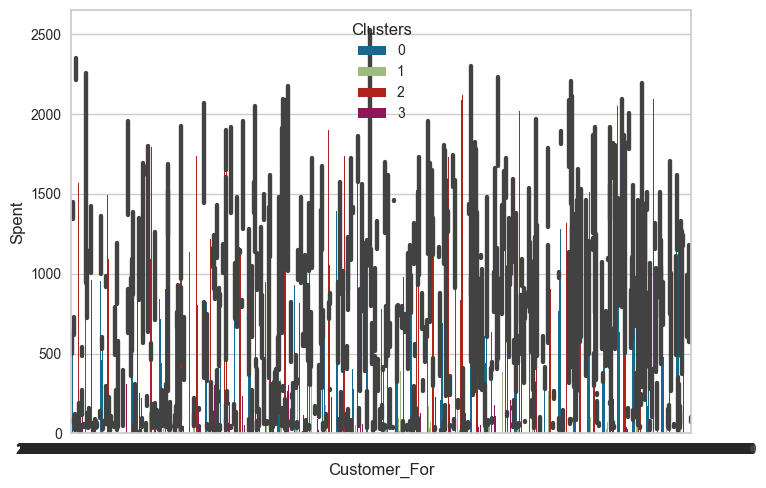

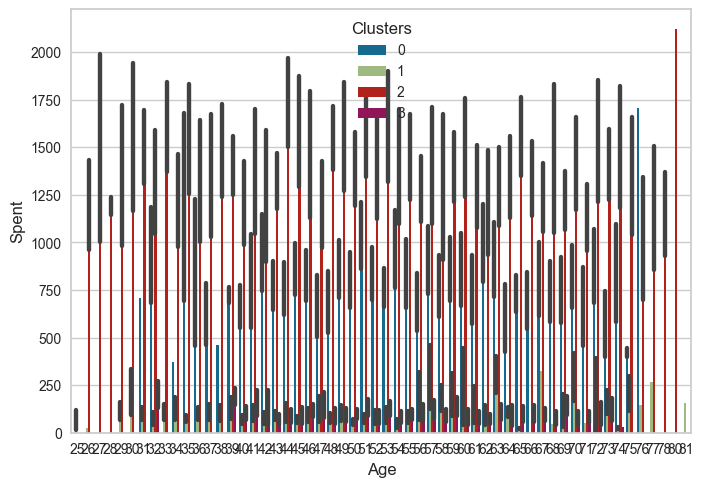

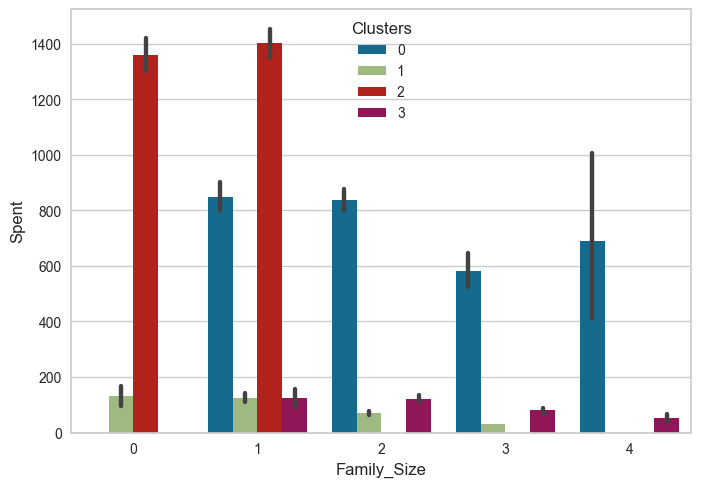

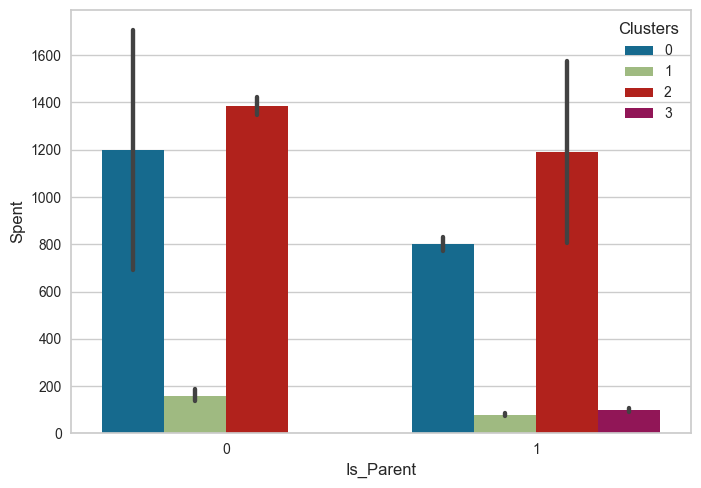

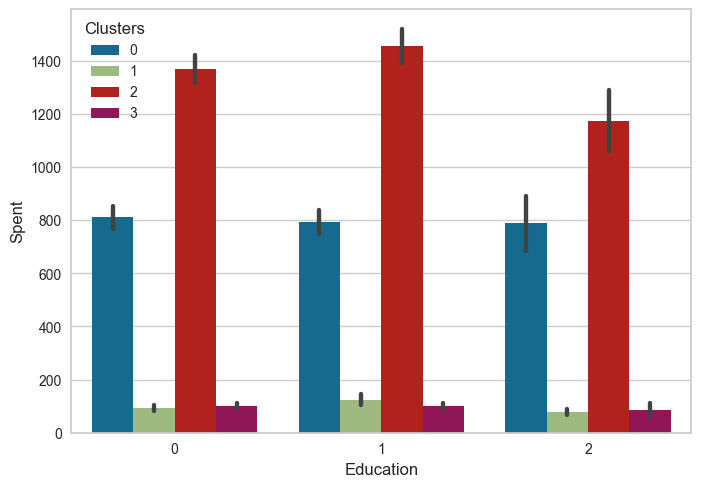

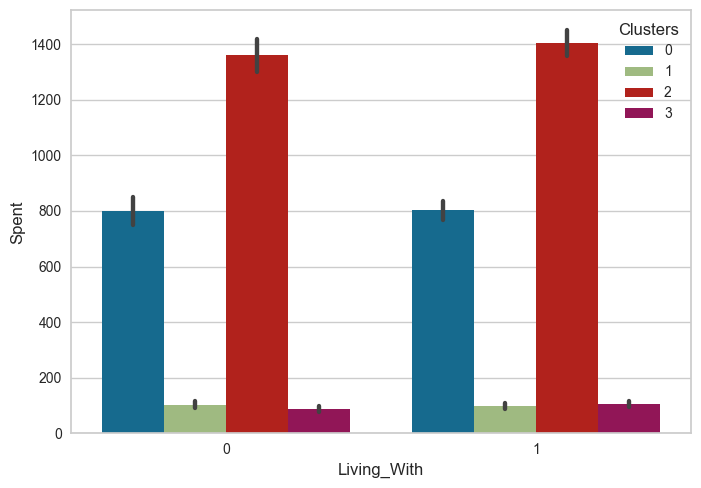

In [54]:
for i in Personal:
    plt.figure()
    sns.barplot(x=data[i], y=data['Spent'], hue=data['Clusters'])
    plt.show()